*Table Of Contents*
- - -
- [Data Shape](#data_shape)
  - [Colosseum scenarios](#data_shape_colosseum_scenarios)
  - [Average over multiple experiment runs](#data_shape_average_over_multiple_runs)
    - [Fix CPI computation time measurements](#data_shape_average_over_fix_cpi)
- [GenSync Performance On Colosseum](#performance_on_colosseum)
  - [Rome Scenario](#results_rome)
  - [Boston and POWDER Scenarios](#results_boston_and_powder)
- [TCP Network Performance On Colosseum](#net_performance)
  - [Latency](#net_performance_latency)
  - [Bandwidth](#net_performance_bandwidth)
- - -

In [60]:
%load_ext autoreload
%autoreload 2

import os
from typing import List, Union

# Dependencies
import matplotlib.pyplot as plt
import pandas as pd

# Local
import colosseum_analysis as ca

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name="data_shape"></a>
# Data Shape
We can get the raw data using `parse`.

In [61]:
d_1017_raw = ca.parse('plain_data/gensync_985751322_1017.csv')
d_1017_raw

,algorithm,server,client,cardinality,success,bytes transmitted,bytes received,communication time(s),idle time(s),computation time(s)
0,CPI,0,0,10000,True,13.0,62.0,0.480089,0.000000,30.020700
1,CPI,0,0,10000,True,62.0,13.0,0.359874,0.265700,0.000033
2,CPI,0,0,10000,True,13.0,62.0,0.480092,0.000000,0.130434
3,CPI,0,0,10000,True,62.0,13.0,0.359872,0.286035,0.000028
4,CPI,0,0,10000,True,13.0,62.0,0.479927,0.000000,0.129543
...,...,...,...,...,...,...,...,...,...,...
1315,Cuckoo,1000,1000,10000,True,36023.0,35964.0,0.548040,0.081242,0.038412
1316,Cuckoo,1000,1000,10000,True,21590.0,36023.0,0.441711,0.000000,0.040792
1317,Cuckoo,1000,1000,10000,True,36023.0,35964.0,0.546906,0.081442,0.039721
1318,Cuckoo,1000,1000,10000,True,21590.0,36023.0,0.441867,0.000000,0.040778


Each data set parsed this way contains an even number of rows. A row with an even index represents the *GenSync* server's view, while rows with odd indices represent the corresponding client views.

We can also get summary dataset using the `summarize` option.

In [62]:
d_1017 = ca.parse('plain_data/gensync_985751322_1017.csv', summarize=True)
d_1017

,algorithm,diffs,cardinality,success,bytes exchanged,ttr
0,CPI,0,10000,True,75.0,30.500789
1,CPI,0,10000,True,75.0,0.645935
2,CPI,0,10000,True,75.0,0.645802
3,CPI,0,10000,True,75.0,0.620693
4,CPI,0,10000,True,75.0,28.222602
...,...,...,...,...,...,...
655,Cuckoo,1000,10000,True,71987.0,0.658211
656,Cuckoo,1000,10000,True,71987.0,0.679445
657,Cuckoo,1000,10000,True,71987.0,0.667694
658,Cuckoo,1000,10000,True,71987.0,0.668069


Here each row represents one experiment run. `bytes exchanged` is the summary communication among the peers. `ttr` is the total time to reconcile.
Total time to reconcile (TTR) is obtained by combining each pair of rows in the raw data using 

$$TTR = \max_{server, client}( computeTime + communicationTime + idleTime ).$$

And the communication cost (COM) is obtained by summing `bytes transmitted` and `bytes received`.

To get the number of experiment runs for each `algorithm`, `diffs` and `cardinality`:

In [63]:
d_1017_groups = d_1017.groupby(['algorithm', 'diffs', 'cardinality'])
len(d_1017_groups.groups[('CPI', 10, 10000)])

10

The number of different cardinalities in the data set is

In [64]:
len(d_1017['cardinality'].unique())

1

<a name="data_shape_colosseum_scenarios"></a>
## Colosseum Scenarios
Each `csv` file is obtained under single Colosseum cellular [scenario](https://colosseumneu.freshdesk.com/support/solutions/articles/61000295793). 

Next we plot the TTR performance of the three algorithms against differences count under scenario 1017. `d_1017` contains the measurements for the "Rome" scenario where devices are static and close to the base station (within 20 m). `d_1018` holds data for the similar scenario where the devices move moderately (up to 3 m/s).

In [65]:
d_1018 = ca.parse('plain_data/gensync_974396656_1018.csv', summarize=True)

<a name="data_shape_average_over_multiple_runs"></a>
## Average over multiple experiment runs
How many experiment runs is enough to get reasonably accurate mean TTR over all experiment runs?

First off, do all algorithms have similar statistical features?

In [66]:
d_1017_CPI_10 = d_1017.loc[d_1017_groups.groups[('CPI', 10, 10000)]]
d_1017_CPI_10

,algorithm,diffs,cardinality,success,bytes exchanged,ttr
330,CPI,10,10000,True,231.0,30.568804
331,CPI,10,10000,True,231.0,28.721739
332,CPI,10,10000,True,231.0,1.624702
333,CPI,10,10000,True,231.0,5.382294
334,CPI,10,10000,True,231.0,26.898956
335,CPI,10,10000,True,231.0,0.822753
336,CPI,10,10000,True,231.0,0.885706
337,CPI,10,10000,True,231.0,0.638614
338,CPI,10,10000,True,231.0,0.652970
339,CPI,10,10000,True,231.0,5.465376


Why do some of these runs have this huge `ttr`?
- Some runs just have very high computation times.

In [67]:
d_1017_raw[(d_1017_raw['algorithm'] == 'CPI') & (d_1017_raw['server'] == 10)]

,algorithm,server,client,cardinality,success,bytes transmitted,bytes received,communication time(s),idle time(s),computation time(s)
660,CPI,10,10,10000,True,89.0,142.0,0.480904,0.000000,30.087900
661,CPI,10,10,10000,True,142.0,89.0,0.361817,0.262686,0.000084
662,CPI,10,10,10000,True,89.0,142.0,0.481239,0.000000,28.240500
663,CPI,10,10,10000,True,142.0,89.0,0.362096,0.283720,0.000105
664,CPI,10,10,10000,True,89.0,142.0,0.481402,0.000000,1.143300
665,CPI,10,10,10000,True,142.0,89.0,0.361839,0.294377,0.000081
666,CPI,10,10,10000,True,89.0,142.0,0.481154,0.000000,4.901140
667,CPI,10,10,10000,True,142.0,89.0,0.361877,0.291904,0.000074
668,CPI,10,10,10000,True,89.0,142.0,0.480956,0.000000,26.418000
669,CPI,10,10,10000,True,142.0,89.0,0.362078,0.261530,0.000083


The statistics of CPI with 10 differences is

In [68]:
d_1017_CPI_10['ttr'].describe()

count    10.000000
mean     10.166191
std      12.966641
min       0.638614
25%       0.838491
50%       3.503498
75%      21.540561
max      30.568804
Name: ttr, dtype: float64

Text(0.5, 1.0, 'CPI')

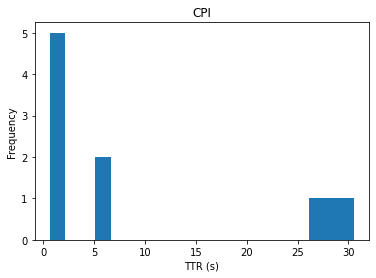

In [69]:
ax = d_1017_CPI_10['ttr'].plot.hist(bins=20)
ax.set_xlabel('TTR (s)')
ax.set_title('CPI')

The variance is very high, it's hard to tell whether these on the far right are outliers. And it appears to hold for many different `diff` values.

In [70]:
diffs_of_interest = range(200, 1100, 100)
cpi_all_d = [d_1017.loc[d_1017_groups.groups[('CPI', i, 10000)]] for i in diffs_of_interest]
for d, i in zip(cpi_all_d, diffs_of_interest):
    print(f"For diffs = {i}\n{d.describe()}")

For diffs = 200
       bytes exchanged        ttr
count             10.0  10.000000
mean            3271.0  22.676541
std                0.0  11.511230
min             3271.0   0.888714
25%             3271.0  27.502187
50%             3271.0  27.588068
75%             3271.0  27.737027
max             3271.0  30.848822
For diffs = 300
       bytes exchanged        ttr
count        10.000000  10.000000
mean       4870.900000  14.479567
std           0.316228  13.809552
min        4870.000000   1.358848
25%        4871.000000   1.371767
50%        4871.000000  14.379007
75%        4871.000000  27.393471
max        4871.000000  28.372030
For diffs = 400
       bytes exchanged        ttr
count        10.000000  10.000000
mean       6470.800000  14.900072
std           0.421637  13.413069
min        6470.000000   2.099767
25%        6471.000000   2.208884
50%        6471.000000  14.644735
75%        6471.000000  27.076657
max        6471.000000  29.752376
For diffs = 500
       bytes excha

Does this happen with other algorithms?

Text(0.5, 0, 'TTR (s)')

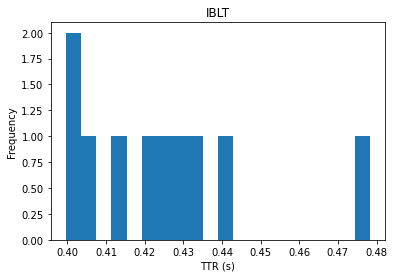

In [71]:
d_1017_IBLT_200 = d_1017.loc[d_1017_groups.groups[('IBLT', 200, 10000)]]
ax = d_1017_IBLT_200['ttr'].plot.hist(bins=20)
ax.set_title('IBLT')
ax.set_xlabel('TTR (s)')

Text(0.5, 0, 'TTR (s)')

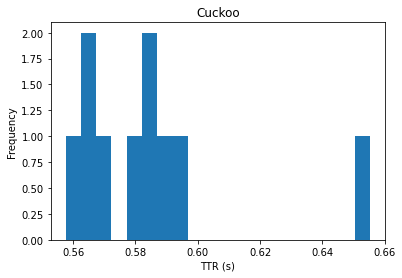

In [72]:
d_1017_Cuckoo_200 = d_1017.loc[d_1017_groups.groups[('Cuckoo', 200, 10000)]]
ax = d_1017_Cuckoo_200['ttr'].plot.hist(bins=20)
ax.set_title('Cuckoo')
ax.set_xlabel('TTR (s)')

- No. Only with CPI.

How many experiment runs we need to reach some reasonable confidence in estimating TTR for CPI?
- Maybe 100?

The following are the experiments for only CPI where each experiment is repeated 100 times. The experiments are partially done (reservation was 6 hours long and got interrupted before completion).

In [73]:
d_1017_CPI_only = ca.parse('plain_data/gensync_464242008_1017_CPI_only.csv', summarize=True)
d_1017_CPI_only[d_1017_CPI_only['diffs'] == 90]

,algorithm,diffs,cardinality,success,bytes exchanged,ttr
0,CPI,90,10000,True,1511.0,0.751583
1,CPI,90,10000,True,1511.0,26.837222
2,CPI,90,10000,True,1511.0,27.981921
3,CPI,90,10000,True,1511.0,27.993825
4,CPI,90,10000,True,1511.0,0.747939
...,...,...,...,...,...,...
95,CPI,90,10000,True,1511.0,28.002335
96,CPI,90,10000,True,1511.0,0.734917
97,CPI,90,10000,True,1511.0,27.961921
98,CPI,90,10000,True,1511.0,0.753598


In [74]:
d_1017_CPI_only[d_1017_CPI_only['diffs'] == 90]['ttr'].describe()

count    100.000000
mean      16.193078
std       13.429459
min        0.716781
25%        0.736996
50%       27.378014
75%       27.974657
max       28.004620
Name: ttr, dtype: float64

Text(0.5, 1.0, 'CPI')

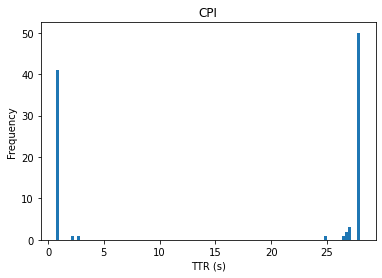

In [75]:
ax = d_1017_CPI_only[d_1017_CPI_only['diffs'] == 90]['ttr'].plot.hist(bins=100)
ax.set_xlabel('TTR (s)')
ax.set_title('CPI')

Does it still comes from the compute time?

In [76]:
d_1017_CPI_only_raw = ca.parse('plain_data/gensync_464242008_1017_CPI_only.csv')
d_1017_CPI_only_raw_50 = d_1017_CPI_only_raw[d_1017_CPI_only_raw['server'] == 50]
d_1017_CPI_only_raw_50

,algorithm,server,client,cardinality,success,bytes transmitted,bytes received,communication time(s),idle time(s),computation time(s)
800,CPI,50,50,10000,True,409.0,462.0,0.483284,0.000000,0.193982
801,CPI,50,50,10000,True,462.0,409.0,0.386473,0.295366,0.000204
802,CPI,50,50,10000,True,409.0,462.0,0.483268,0.000000,0.151828
803,CPI,50,50,10000,True,462.0,409.0,0.377268,0.283237,0.000206
804,CPI,50,50,10000,True,409.0,462.0,0.483109,0.000000,27.645100
...,...,...,...,...,...,...,...,...,...,...
995,CPI,50,50,10000,True,462.0,409.0,0.377456,0.266922,0.000220
996,CPI,50,50,10000,True,409.0,462.0,0.483345,0.000000,27.651500
997,CPI,50,50,10000,True,462.0,409.0,0.377234,0.284560,0.000220
998,CPI,50,50,10000,True,409.0,462.0,0.483218,0.000000,0.165392


In [77]:
d_1017_CPI_only_raw_50['communication time(s)'].describe()

count    200.000000
mean       0.430668
std        0.052801
min        0.376361
25%        0.377332
50%        0.434787
75%        0.483302
max        0.483617
Name: communication time(s), dtype: float64

In [78]:
d_1017_CPI_only_raw_50['idle time(s)'].describe()

count    200.000000
mean       0.141664
std        0.142407
min        0.000000
25%        0.000000
50%        0.129233
75%        0.283249
max        0.314135
Name: idle time(s), dtype: float64

In [79]:
d_1017_CPI_only_raw_50['computation time(s)'].describe()

count    200.000000
mean       6.680225
std       11.774092
min        0.000203
25%        0.000215
50%        0.062938
75%        1.162057
max       28.019600
Name: computation time(s), dtype: float64

Is this computation time only on the server side?

In [80]:
[x for x in d_1017_CPI_only_raw_50[d_1017_CPI_only_raw_50['computation time(s)'] > 15].index if x % 2]

[]

Thus, it seems like it's only on the server side.

<a name="data_shape_average_over_fix_cpi"></a>
### Fix CPI computation time measurements

It turns out that our CPI server computation time measurements were not implemented correctly when GenSync is compiled with `IGNORE_SERVER_IDLE` option. Now it is fixed and CPI experiments are rerun.

In [81]:
d_1017_fix = ca.parse('plain_data/gensync_151036073_1017.csv', summarize=True)
d_1017_fix[d_1017_fix['diffs'] == 50]['ttr'].describe()

count    10.000000
mean      0.662244
std       0.021494
min       0.639352
25%       0.646105
50%       0.658789
75%       0.671983
max       0.710914
Name: ttr, dtype: float64

Next, we will combine the data frames from this experiment with the one from the previous runs.

In [82]:
d_1017 = ca.fix(d_1017, d_1017_fix)
d_1017[(d_1017['algorithm'] == 'CPI') & (d_1017['diffs'] == 10)]

,algorithm,diffs,cardinality,success,bytes exchanged,ttr
520,CPI,10,10000,True,231.0,0.644389
521,CPI,10,10000,True,231.0,0.660261
522,CPI,10,10000,True,231.0,0.648104
523,CPI,10,10000,True,231.0,0.632232
524,CPI,10,10000,True,231.0,0.620704
525,CPI,10,10000,True,231.0,0.657554
526,CPI,10,10000,True,231.0,0.655473
527,CPI,10,10000,True,231.0,0.654131
528,CPI,10,10000,True,231.0,0.622770
529,CPI,10,10000,True,231.0,0.637173


In [83]:
d_1017.shape

(660, 6)

In [84]:
5025.0 / 0.251810

19955.52202057107

In [85]:
d_1018_fix = ca.parse('plain_data/gensync_968760679_1018.csv', summarize=True)
d_1018 = ca.fix(d_1018, d_1018_fix)
d_1018[(d_1018['algorithm'] == 'CPI') & (d_1018['diffs'] == 10)]

,algorithm,diffs,cardinality,success,bytes exchanged,ttr
520,CPI,10,10000,True,231.0,0.653457
521,CPI,10,10000,True,231.0,0.644646
522,CPI,10,10000,True,231.0,0.652675
523,CPI,10,10000,True,231.0,0.629291
524,CPI,10,10000,True,231.0,0.655896
525,CPI,10,10000,True,231.0,0.633967
526,CPI,10,10000,True,231.0,0.634764
527,CPI,10,10000,True,231.0,0.656365
528,CPI,10,10000,True,231.0,0.643659
529,CPI,10,10000,True,231.0,0.637199


The data is now more accurate.

<a name="performance_on_colosseum"></a>
# GenSync Performance On Colosseum
We analyze the initial results obtained from the following scenarios:
- Rome close static (1017): 3 user devices, 1 base station, users are static and within 20 m from the base station, and
- Rome close moderate (1018): users are moving at ~3 m/s within 20 m from the base station.
- Rome far static (1019): users are static, but further from the base station (within 100 m).
- Boston close static (1031)
- Boston close moderate (1033)
- Boston far static (1024)
- POWDER close static (1025)
- POWDER close moderate (1026)
- POWDER far static (1027)

Data parameters are $|S_A| = |S_B| = 10000$ and $10 <= d <= 1000$ (by 10 to 100, then by 100 to 1000). Each experiment is repeated 10 times.

In these experiments, synchronization is done among two users while the third is idle (does not transmit or receive any traffic).

<a name="results_rome"></a>
## Rome Scenario

In [86]:
def get_algo_data(algo: str, data: pd.DataFrame):
    return data[data['algorithm'] == algo]

In [87]:
CPI_1017 = get_algo_data('CPI', d_1017)
IBLT_1017 = get_algo_data('IBLT', d_1017)
Cuckoo_1017 = get_algo_data('Cuckoo', d_1017)

In [88]:
CPI_1018 = get_algo_data('CPI', d_1018)
IBLT_1018 = get_algo_data('IBLT', d_1018)
Cuckoo_1018 = get_algo_data('Cuckoo', d_1018)

In [89]:
def get_xs_ys(data: pd.DataFrame): 
    g = data.groupby('diffs')
    diffs = g.groups.keys()
    stat = g.apply(lambda x: x.describe())['ttr']
    ttrs = [stat.xs(d)['mean'] for d in diffs]
    return diffs, ttrs

In [90]:
def plot_ttr(data: List[pd.DataFrame], labels: List[str], axis=plt, title=None) -> None:
    x_label = 'Symmetric Differences (d)'
    y_label = 'TTR (s)'
    
    for d in data:
        xs, ys = get_xs_ys(d)
        axis.plot(xs, ys)
        
    axis.legend(labels)
    axis.xlabel(x_label) if type(axis) == type(plt) else axis.set_xlabel(x_label)
    axis.ylabel(y_label) if type(axis) == type(plt) else axis.set_ylabel(y_label)
    if title:
        axis.title(title) if type(axis) == type(plt) else axis.set_title(title)

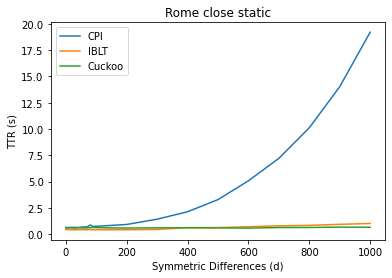

In [91]:
plot_ttr([CPI_1017, IBLT_1017, Cuckoo_1017], ['CPI', 'IBLT', 'Cuckoo'], title='Rome close static')

Above is what happens when the nodes are static. The following is what happens when the nodes move moderately (*i.e*, at about 3 m/s)

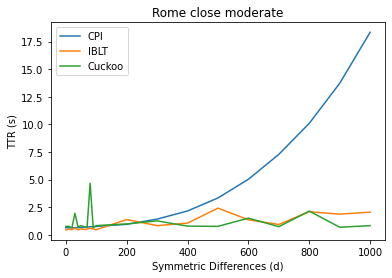

In [92]:
plot_ttr([CPI_1018, IBLT_1018, Cuckoo_1018], ['CPI', 'IBLT', 'Cuckoo'], title='Rome close moderate')

Next, let's plot what happens when the nodes are static but now at around 100 m.

In [93]:
d_1019 = ca.parse('plain_data/gensync_716773447_1019.csv', summarize=True)

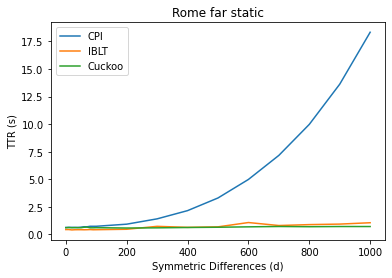

In [94]:
CPI_1019 = get_algo_data('CPI', d_1019)
IBLT_1019 = get_algo_data('IBLT', d_1019)
Cuckoo_1019 = get_algo_data('Cuckoo', d_1019)

plot_ttr([CPI_1019, IBLT_1019, Cuckoo_1019], ['CPI', 'IBLT', 'Cuckoo'], title='Rome far static')

Which does not differ significantly from the plot when the nodes were within 20 m from the base station. In conclusion, **movements affect the performance** of our algorithms more than the distance from the base station.

The following is a similar plot as above, zooming to IBLT and Cuckoo only.

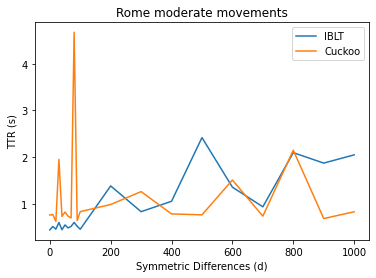

In [95]:
plot_ttr([IBLT_1018, Cuckoo_1018], ['IBLT', 'Cuckoo'], title='Rome moderate movements')

<a name="results_boston_and_powder"></a>
## Boston and POWDER Scenarios

In [96]:
d_1031 = ca.parse('plain_data/gensync_203947479_1031.csv', summarize=True)
d_1033 = ca.parse('plain_data/gensync_849071254_1033.csv', summarize=True)
d_1024 = ca.parse('plain_data/gensync_020381165_1024.csv', summarize=True)

In [97]:
CPI_1031 = get_algo_data('CPI', d_1031)
IBLT_1031 = get_algo_data('IBLT', d_1031)
Cuckoo_1031 = get_algo_data('Cuckoo', d_1031)

CPI_1033 = get_algo_data('CPI', d_1033)
IBLT_1033 = get_algo_data('IBLT', d_1033)
Cuckoo_1033 = get_algo_data('Cuckoo', d_1033)

CPI_1024 = get_algo_data('CPI', d_1024)
IBLT_1024 = get_algo_data('IBLT', d_1024)
Cuckoo_1024 = get_algo_data('Cuckoo', d_1024)

Text(0.5, 0.98, 'Boston')

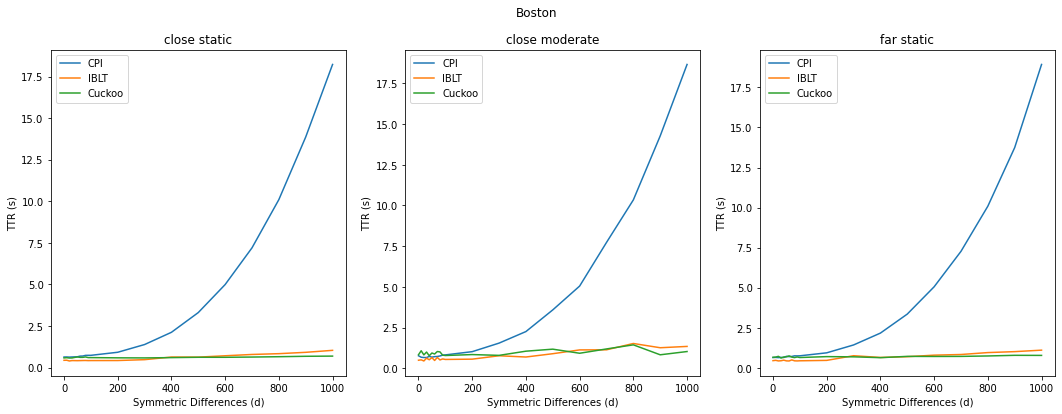

In [98]:
figure, axis = plt.subplots(1, 3, figsize=(18, 6))
plot_ttr([CPI_1031, IBLT_1031, Cuckoo_1031], ['CPI', 'IBLT', 'Cuckoo'], title='close static', axis=axis[0])
plot_ttr([CPI_1033, IBLT_1033, Cuckoo_1033], ['CPI', 'IBLT', 'Cuckoo'], title='close moderate', axis=axis[1])
plot_ttr([CPI_1024, IBLT_1024, Cuckoo_1024], ['CPI', 'IBLT', 'Cuckoo'], title='far static', axis=axis[2])
figure.suptitle('Boston')

In [99]:
d_1025 = ca.parse('plain_data/gensync_081328890_1025.csv', summarize=True)
d_1026 = ca.parse('plain_data/gensync_775034327_1026.csv', summarize=True)
d_1027 = ca.parse('plain_data/gensync_863458421_1027.csv', summarize=True)

In [100]:
CPI_1025 = get_algo_data('CPI', d_1025)
IBLT_1025 = get_algo_data('IBLT', d_1025)
Cuckoo_1025 = get_algo_data('Cuckoo', d_1025)

CPI_1026 = get_algo_data('CPI', d_1026)
IBLT_1026 = get_algo_data('IBLT', d_1026)
Cuckoo_1026 = get_algo_data('Cuckoo', d_1026)

CPI_1027 = get_algo_data('CPI', d_1027)
IBLT_1027 = get_algo_data('IBLT', d_1027)
Cuckoo_1027 = get_algo_data('Cuckoo', d_1027)

Text(0.5, 0.98, 'POWDER')

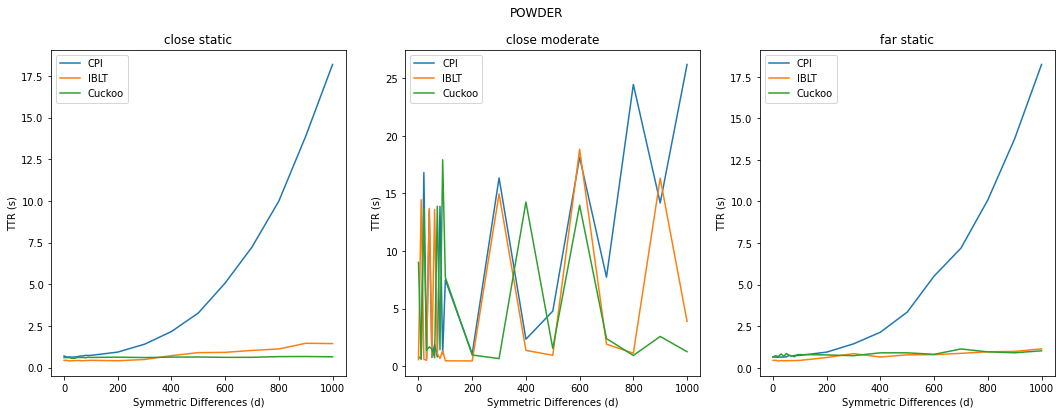

In [101]:
figure, axis = plt.subplots(1, 3, figsize=(18, 6))
plot_ttr([CPI_1025, IBLT_1025, Cuckoo_1025], ['CPI', 'IBLT', 'Cuckoo'], title='close static', axis=axis[0])
plot_ttr([CPI_1026, IBLT_1026, Cuckoo_1026], ['CPI', 'IBLT', 'Cuckoo'], title='close moderate', axis=axis[1])
plot_ttr([CPI_1027, IBLT_1027, Cuckoo_1027], ['CPI', 'IBLT', 'Cuckoo'], title='far static', axis=axis[2])
figure.suptitle('POWDER')

In [102]:
d_1026[(d_1026['algorithm'] == 'IBLT') & (d_1026['diffs'] == 900)]

,algorithm,diffs,cardinality,success,bytes exchanged,ttr
60,IBLT,900,10000,True,86953.0,0.953743
61,IBLT,900,10000,True,86953.0,1.175118
62,IBLT,900,10000,True,86953.0,1.815438
63,IBLT,900,10000,True,86953.0,1.118748
64,IBLT,900,10000,True,86953.0,0.927589
65,IBLT,900,10000,True,86953.0,1.118300
66,IBLT,900,10000,True,86953.0,135.198167
67,IBLT,900,10000,True,86953.0,5.332366
68,IBLT,900,10000,True,86953.0,13.930619
69,IBLT,900,10000,True,86953.0,1.566037


There is some **huge** variance in ttr here, probably as a result of high variations in network performance.

In [103]:
d_1026[(d_1026['algorithm'] == 'IBLT') & (d_1026['diffs'] == 900)].describe()

,bytes exchanged,ttr
count,10.0,10.000000
mean,86953.0,16.313612
std,0.0,41.967054
min,86953.0,0.927589
25%,86953.0,1.118412
50%,86953.0,1.370578
75%,86953.0,4.453134
max,86953.0,135.198167


In [104]:
d_1026[(d_1026['algorithm'] == 'Cuckoo') & (d_1026['diffs'] == 900)]

,algorithm,diffs,cardinality,success,bytes exchanged,ttr
570,Cuckoo,900,10000,True,70392.0,0.755839
571,Cuckoo,900,10000,True,70392.0,0.636186
572,Cuckoo,900,10000,True,70422.0,0.699587
573,Cuckoo,900,10000,True,70407.0,0.571473
574,Cuckoo,900,10000,True,70392.0,0.557547
575,Cuckoo,900,10000,True,70392.0,19.666684
576,Cuckoo,900,10000,True,70392.0,0.586449
577,Cuckoo,900,10000,True,70407.0,0.633940
578,Cuckoo,900,10000,True,70407.0,1.068419
579,Cuckoo,900,10000,True,70407.0,0.707195


In [105]:
d_1026[(d_1026['algorithm'] == 'CPI') & (d_1026['diffs'] == 900)]

,algorithm,diffs,cardinality,success,bytes exchanged,ttr
640,CPI,900,10000,True,14471.0,14.034420
641,CPI,900,10000,True,14471.0,14.059316
642,CPI,900,10000,True,14471.0,13.737275
643,CPI,900,10000,True,14471.0,13.922481
644,CPI,900,10000,True,14471.0,13.816915
645,CPI,900,10000,True,14471.0,13.848751
646,CPI,900,10000,True,14471.0,15.323459
647,CPI,900,10000,True,14470.0,13.779730
648,CPI,900,10000,True,14471.0,13.784235
649,CPI,900,10000,True,14470.0,15.397564


Can we correlate the variance in ttr performance with the variance in network performance on Colosseum?

<a name="net_performance"></a>
# TCP Network Performance On Colosseum

The Colosseum scenarios that we consider (see [above](#performance_on_colosseum)) last for 600 seconds.

However, our latency and bandwidth measurements do not start right at the first second of the scenario. Instead, our measurements start around 2 minutes after the scenario is activated through `colosseumcli`. This temporal skew is required since USRPs need around 2 minutes to get properly set up and instantiate IP interfaces that we later rely on in our measurements. In the graphs below, we share the time frame that *roughly* corresponds to the duration of the scenario.

<a name="net_performance_latency"></a>
## Latency

Ping RTTs are in milliseconds. The following is POWDER scenario.

In [106]:
net_data_path = 'plain_data/network'  # network measurements raw data dir
def get_net_path(s: str) -> str:
    return os.path.join(net_data_path, s)

In [107]:
ping_1025 = ca.parse_ping(get_net_path('benchmark_net_957228509_1026_ping/ping.txt'))  # close static
ping_1026 = ca.parse_ping(get_net_path('benchmark_net_918629519_1025_ping/ping.txt'))  # close moderate

In [108]:
ping_1025.describe()

,rtt
count,1569.000000
mean,90.364755
std,30.527381
min,57.600000
25%,73.200000
50%,86.300000
75%,98.200000
max,919.000000


In [109]:
ping_1026.describe()

,rtt
count,1799.000000
mean,78.605281
std,11.711344
min,57.600000
25%,68.100000
50%,79.100000
75%,89.100000
max,97.300000


We observe that POWDER "close moderate" has much higher RTT variance than "close static". However, "close moderate" seems to have a **significantly lower mean**. Which is surprising to me...

Now, plotted as time series.

In [110]:
def plot_rtt_time_series(data: Union[pd.DataFrame, List[float]], title: str) -> None:
    if isinstance(data, pd.DataFrame):
        data = data['rtt']
    
    plt.figure(figsize=(28, 6))
    plt.plot(data, marker='o', linestyle='')
    plt.axvspan(520, 1120, color='grey', alpha=.3)  # roughly one scenario duration (first ~80s not measured)
    plt.xlabel('Elapsed Time (s)')
    plt.ylabel('Time (ms)')
    plt.title(title)

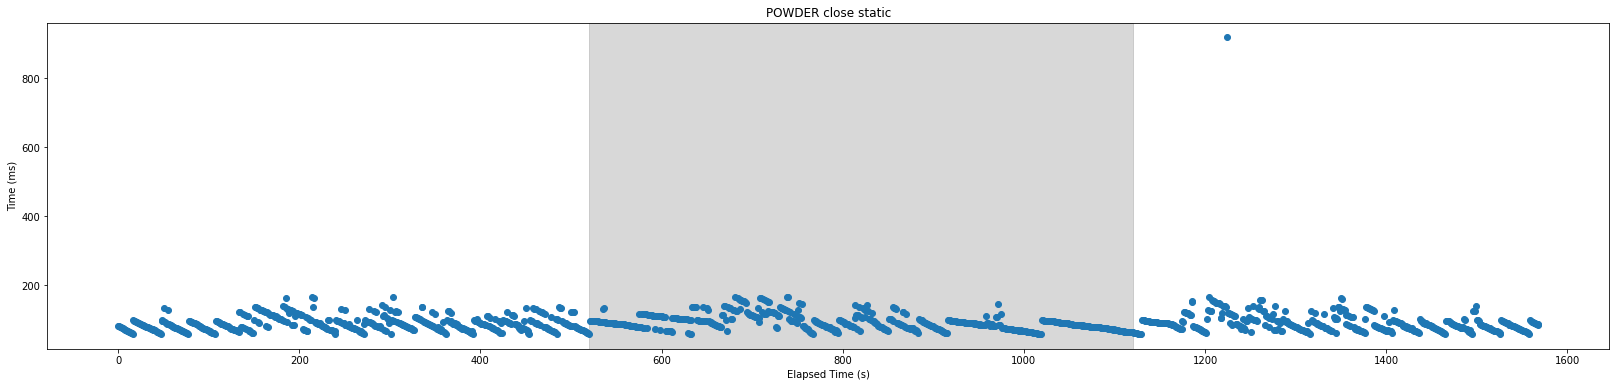

In [111]:
plot_rtt_time_series(ping_1025, title='POWDER close static')

Leaving out this spike, plotting only from 0th to 1200th second.

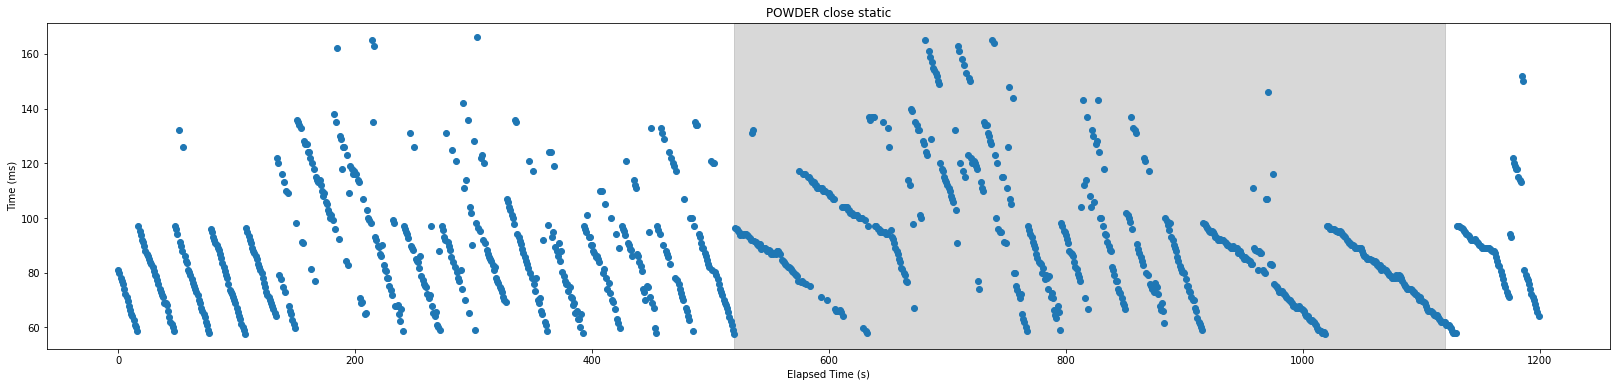

In [112]:
plot_rtt_time_series(ping_1025[:1200], title='POWDER close static')

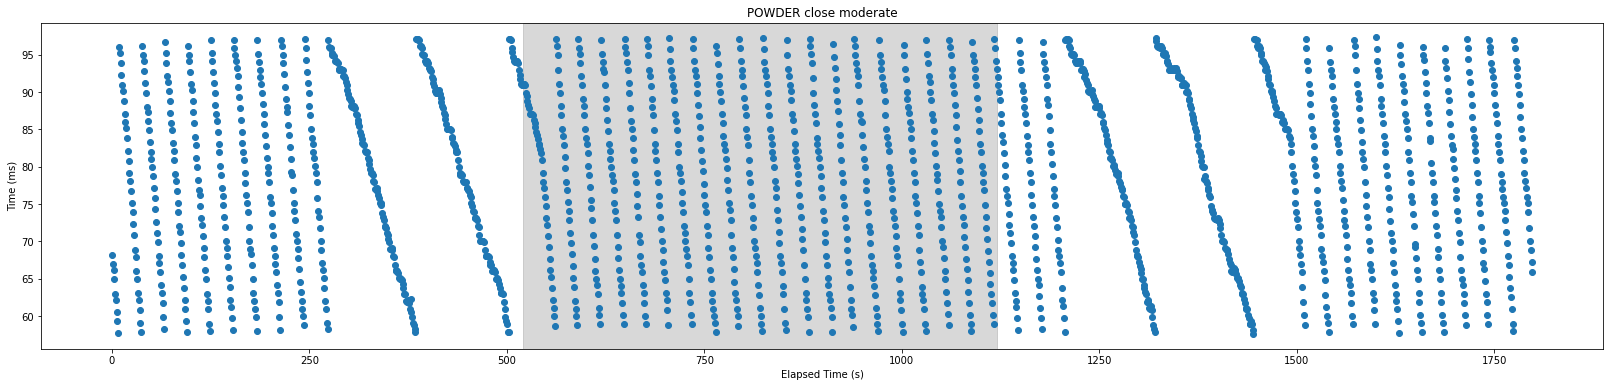

In [113]:
plot_rtt_time_series(ping_1026, title='POWDER close moderate')

<a name="net_performance"></a>
## Bandwidth

In [114]:
iperf_1025_cs = ca.parse_iperf(get_net_path('benchmark_net_332752883_1025_iperf/iperf_client_to_server.json'))
iperf_1025_sc = ca.parse_iperf(get_net_path('benchmark_net_332752883_1025_iperf/iperf_server_to_client.json'))

iperf_1026_cs = ca.parse_iperf(get_net_path('benchmark_net_546262693_1026_iperf/iperf_client_to_server.json'))
iperf_1026_sc = ca.parse_iperf(get_net_path('benchmark_net_546262693_1026_iperf/iperf_server_to_client.json'))

def cnv_Mbps(df: pd.DataFrame) -> pd.DataFrame:
    """Convert bps to Mbps."""
    df['bits_per_second'] = df['bits_per_second'].apply(lambda x: x / 1e+6)
    df = df.rename({'bits_per_second': 'Mbps'}, axis='columns')
    return df

iperf_1025_cs, iperf_1025_sc, iperf_1026_cs, iperf_1026_sc = \
    [cnv_Mbps(d) for d in [iperf_1025_cs, iperf_1025_sc, iperf_1026_cs, iperf_1026_sc]]

POWDER "close static" Client -> Server bandwidth

In [115]:
iperf_1025_cs['Mbps'].describe()

count    1800.000000
mean        1.165091
std         0.295017
min         0.000000
25%         1.042400
50%         1.042500
75%         1.563740
max         2.086540
Name: Mbps, dtype: float64

Server -> Client

In [116]:
iperf_1025_sc['Mbps'].describe()

count    1800.000000
mean        0.525146
std         0.170768
min         0.092642
25%         0.428568
50%         0.532884
75%         0.625621
max         1.528950
Name: Mbps, dtype: float64

POWDER "close moderate" Client -> Server

In [117]:
iperf_1026_cs['Mbps'].describe()

count    1800.000000
mean        0.271036
std         0.437271
min         0.000000
25%         0.000000
50%         0.000000
75%         0.567862
max         2.154850
Name: Mbps, dtype: float64

Server -> Client

In [118]:
iperf_1026_sc['Mbps'].describe()

count    1800.000000
mean        0.465752
std         0.451181
min         0.000000
25%         0.000000
50%         0.370648
75%         0.845633
max         1.644930
Name: Mbps, dtype: float64

Now, plot that as time series.

In [119]:
def plot_iperf_time_series(df: pd.DataFrame, title: str) -> None:
    plt.figure(figsize=(28, 6))
    plt.plot(df['Mbps'], marker='o', linestyle='')
    plt.axvspan(520, 1120, color='grey', alpha=.3)  # roughly one scenario duration (first ~80s not measured)
    plt.xlabel('Time (s)')
    plt.ylabel('Bandwidth (Mbps)')
    plt.title(title)

Client -> Server

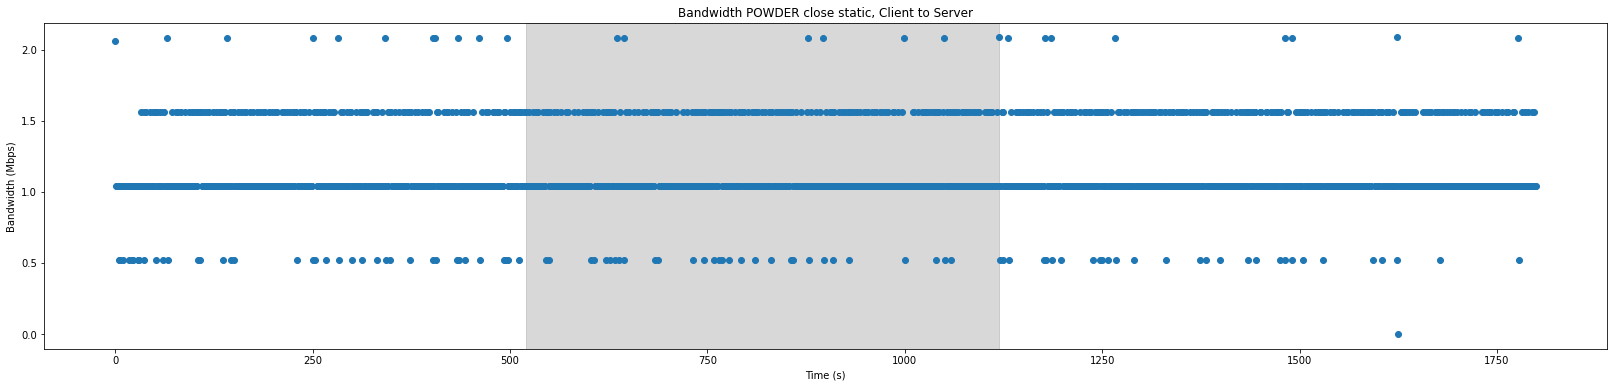

In [120]:
plot_iperf_time_series(iperf_1025_cs, title='Bandwidth POWDER close static, Client to Server')

Server -> Client

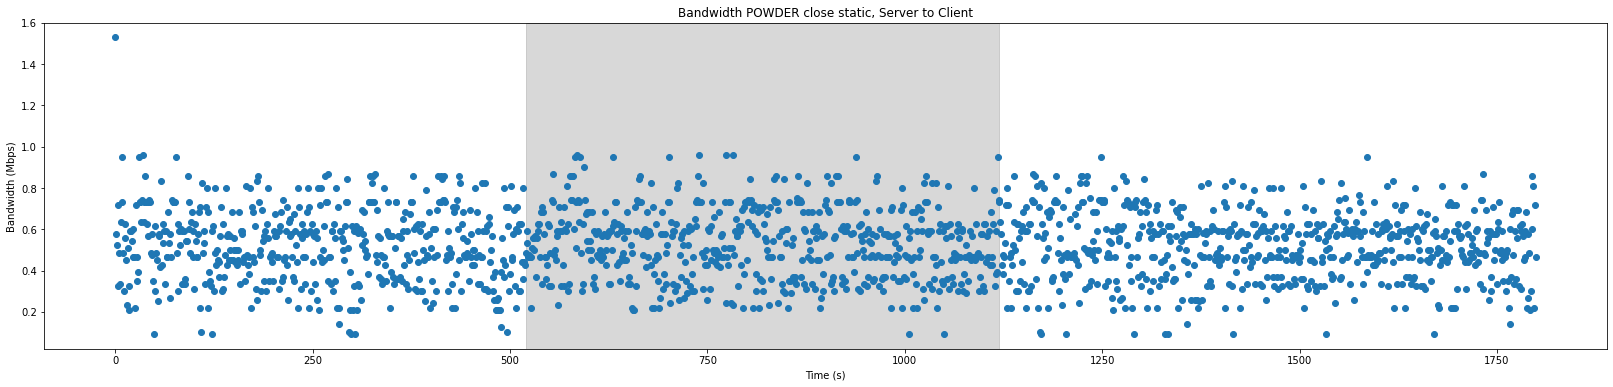

In [121]:
plot_iperf_time_series(iperf_1025_sc, title='Bandwidth POWDER close static, Server to Client')

Clinet -> Server

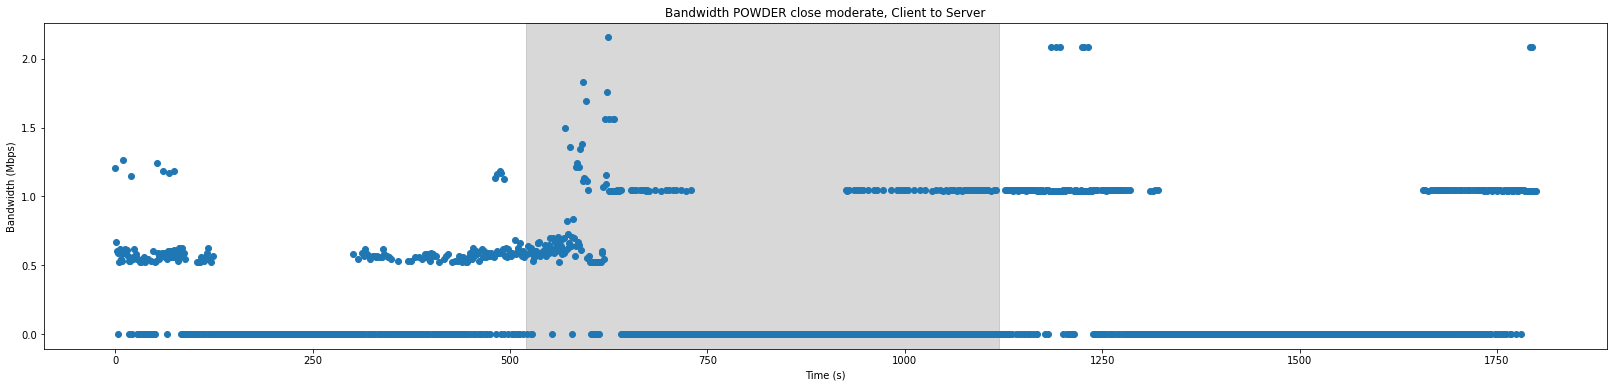

In [122]:
plot_iperf_time_series(iperf_1026_cs, title='Bandwidth POWDER close moderate, Client to Server')

1. can I run iperf3 and ping in two containers (SRN)
2. is latency & bandwidth same when we do SRN -> Base Station and SRN -> SRN? (will you see similar measurements as above?)

A typical scenario takes 10 m = 600s => ping and iperf3 for at least that long.

colosseumcli rf start 1017 -c -> scenario started
?, ~1m until radio software is functional. ~1 in the scenario. 1800s

172.16.0.[1|2|3|4]

ifconfig | grep srs

Server -> Client

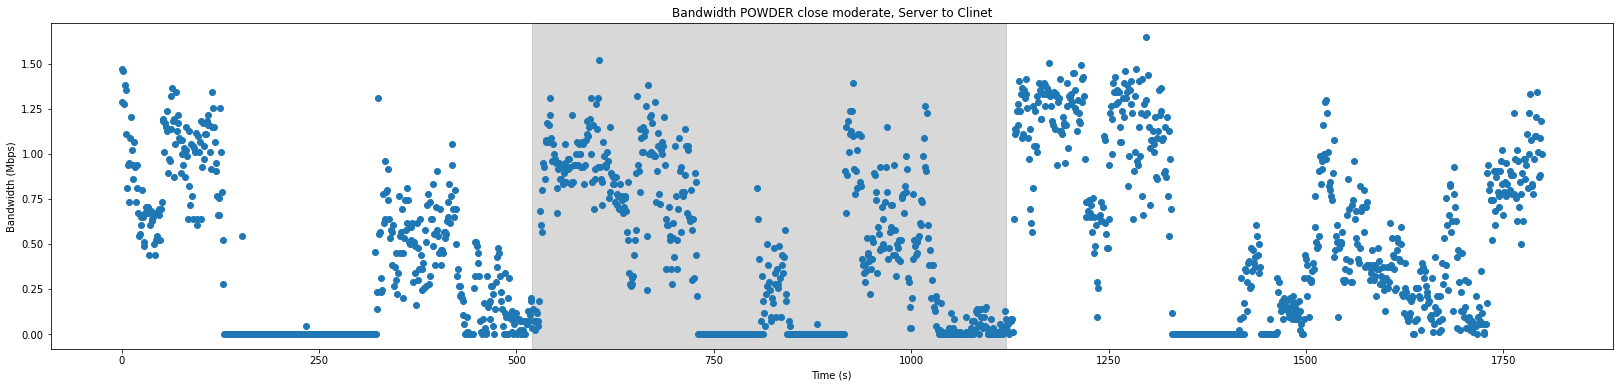

In [123]:
plot_iperf_time_series(iperf_1026_sc, title='Bandwidth POWDER close moderate, Server to Clinet')

### Do these bandwidth fadeouts exist in Rome scenario?

In [124]:
ping_1017 = ca.parse_ping(get_net_path('benchmark_net_377743642_1017/ping.txt'))
iperf_1017_cs = cnv_Mbps(
    ca.parse_iperf(get_net_path('benchmark_net_529954676_1017/iperf_client_to_server.json')))
iperf_1017_sc = cnv_Mbps(
    ca.parse_iperf(get_net_path('benchmark_net_529954676_1017/iperf_server_to_client.json')))

ping_1018 = ca.parse_ping(get_net_path('benchmark_net_126889212_1018/ping.txt'))
iperf_1018_cs = cnv_Mbps(
    ca.parse_iperf(get_net_path('benchmark_net_567662399_1018/iperf_client_to_server.json')))
iperf_1018_sc = cnv_Mbps(
    ca.parse_iperf(get_net_path('benchmark_net_567662399_1018/iperf_server_to_client.json')))

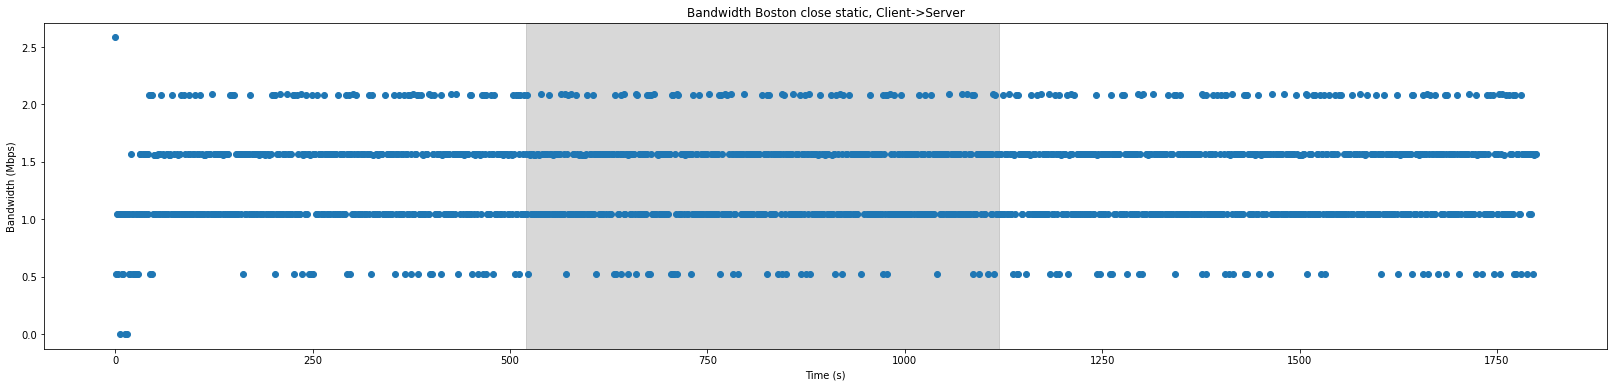

In [125]:
plot_iperf_time_series(iperf_1017_cs, title='Bandwidth Boston close static, Client->Server')

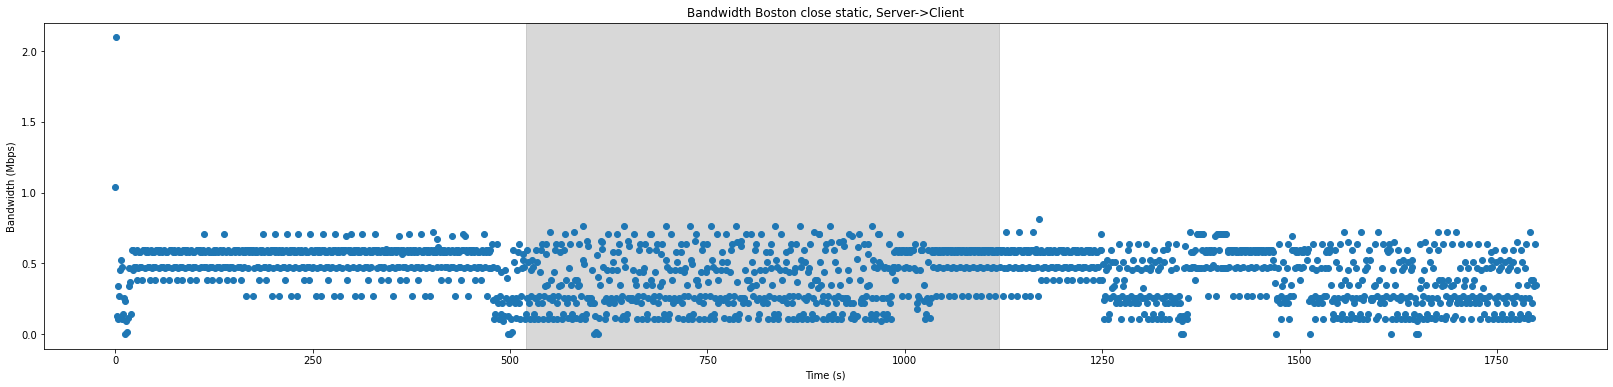

In [126]:
plot_iperf_time_series(iperf_1017_sc, title='Bandwidth Boston close static, Server->Client')

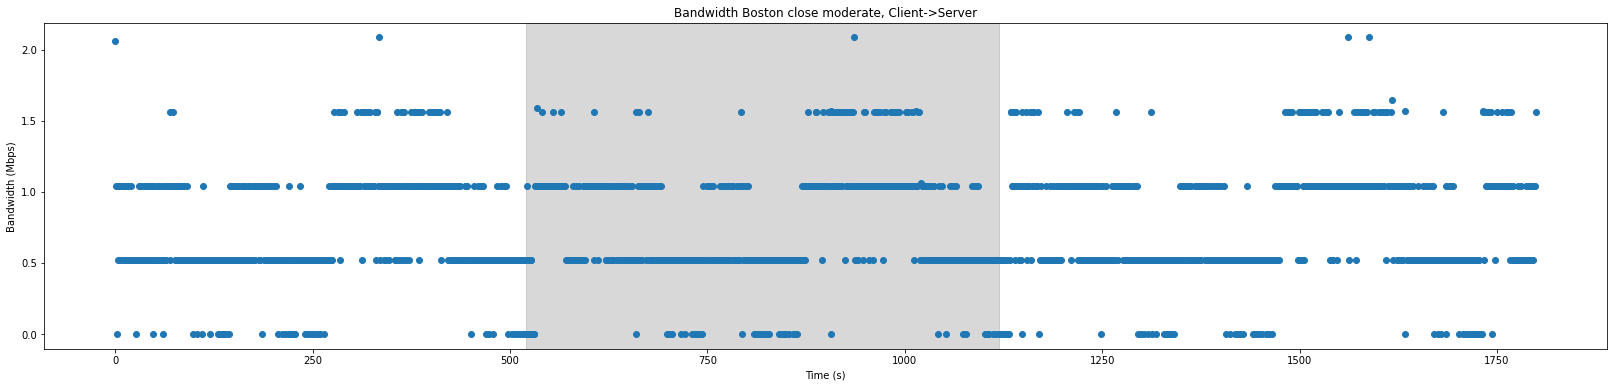

In [127]:
plot_iperf_time_series(iperf_1018_cs, title='Bandwidth Boston close moderate, Client->Server')

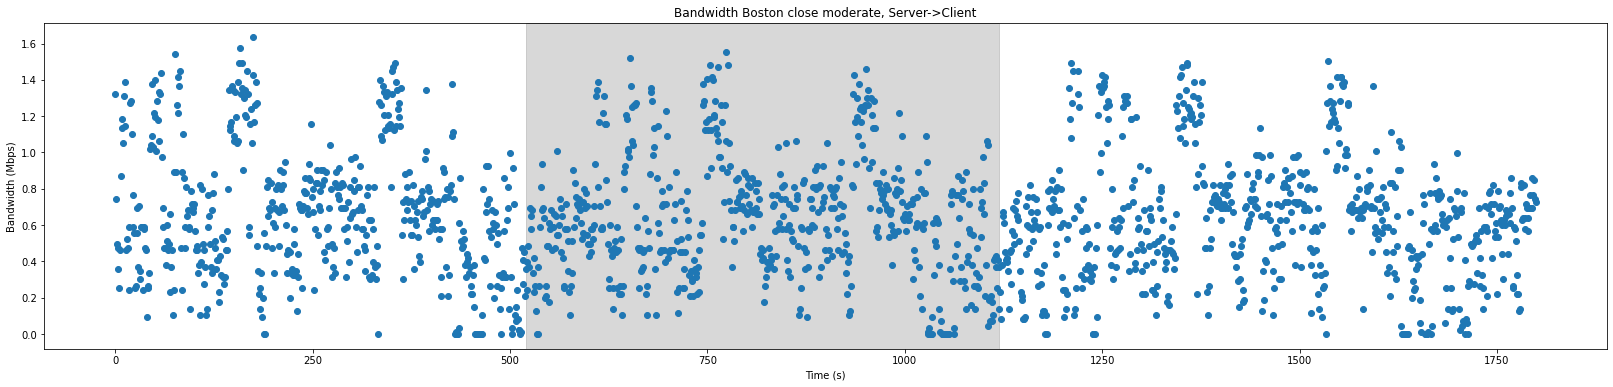

In [128]:
plot_iperf_time_series(iperf_1018_sc, title='Bandwidth Boston close moderate, Server->Client')

In the cases with moderate node mobility there is significant amount of "dropouts".

## Can We Learn the Trends in Bandwidth Time Series?

In [129]:
one_window = iperf_1026_sc[520:1120]                     # constrain our analysis to only one window
data = one_window.copy()                                 
data = data[['start', 'Mbps']]
data['start'] = pd.to_datetime(data['start'], unit='s')  # convert to time series, formally
data = data.set_index('start')
data.head()

,Mbps
start,
1970-01-01 00:08:40.000,0.034751
1970-01-01 00:08:41.000,0.139008
1970-01-01 00:08:42.000,0.069505
1970-01-01 00:08:43.000,0.023150
1970-01-01 00:08:44.001,0.069513


In [130]:
data.shape

(600, 1)

Let's plot rolling mean and standard deviation alongside this data window (default window is 60 seconds).

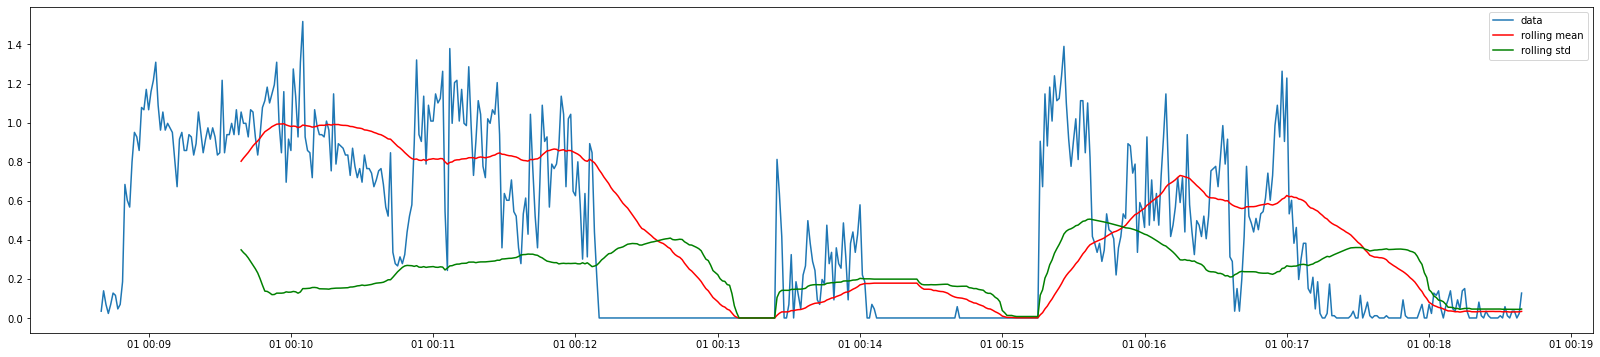

In [131]:
def plot_moving_avg_std(data: pd.DataFrame, window=60) -> None:
    r_mean = data.rolling(window).mean()
    r_std = data.rolling(window).std()
    
    plt.figure(figsize=(28, 6))
    plt.plot(data, label='data')
    plt.plot(r_mean, label='rolling mean', color='r')
    plt.plot(r_std, label='rolling std', color='g')
    plt.legend()
    
plot_moving_avg_std(data, window=60)

With the smaller window (*e.g.*, 10), we get better predictions. However there is a question of how do we efficiently keep these average statistics in the periodic synchronization case (**TODO**).

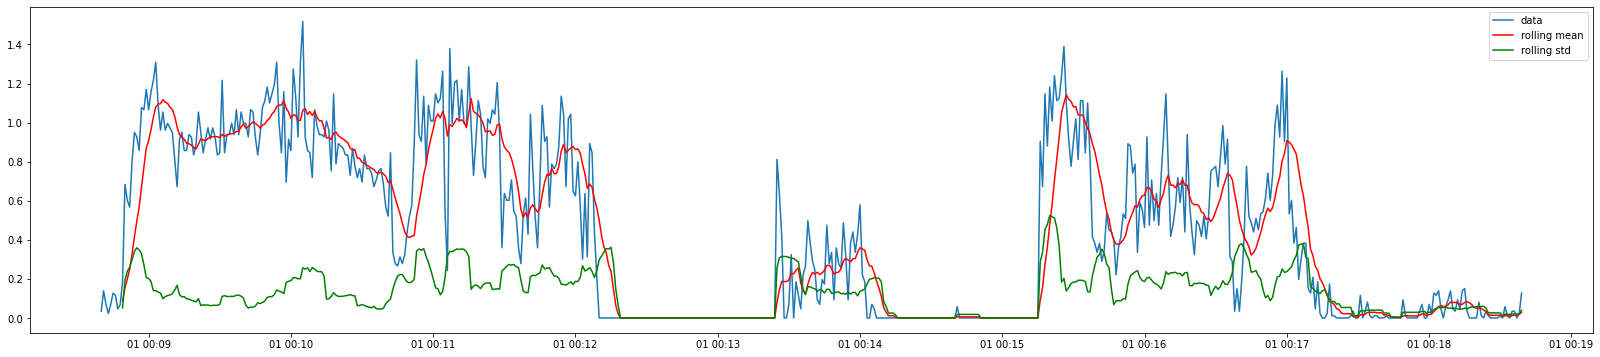

In [132]:
plot_moving_avg_std(data, window=10)

### Stationarity Test
Perform [Dickey-Fuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) stationarity test.

In [133]:
from statsmodels.tsa.stattools import adfuller
adfuller(data)

(-3.0988315750034583,
 0.026639778087209798,
 3,
 596,
 {'1%': -3.4413696108194607,
  '5%': -2.8664016052801906,
  '10%': -2.569359115918202},
 -435.2283281255436)

Since `-3.09 < -2.86` we can reject the Dickey-Fuller null hypothesis ("the series is non-stationary") with 95% confidence (as per my understanding **TODO**).

Stationarity can help us predict bandwidth at some future times. But I don't think such a prediction would be of practical importance for our "adaptive synchronization" as we may not know where in the scenario we currently are.

However, when we consider periodic reconciliation, we can actually keep moving averages to predict future bandwidth and latency values.

## Boston Scenario Bandwidth

In [134]:
iperf_1033_sc = ca.parse_iperf(get_net_path('benchmark_net_904926021_1033_iperf/iperf_server_to_client.json'))
iperf_1033_cs = ca.parse_iperf(get_net_path('benchmark_net_904926021_1033_iperf/iperf_client_to_server.json'))

In [135]:
iperf_1033_sc = cnv_Mbps(iperf_1033_sc)
iperf_1033_cs = cnv_Mbps(iperf_1033_cs)

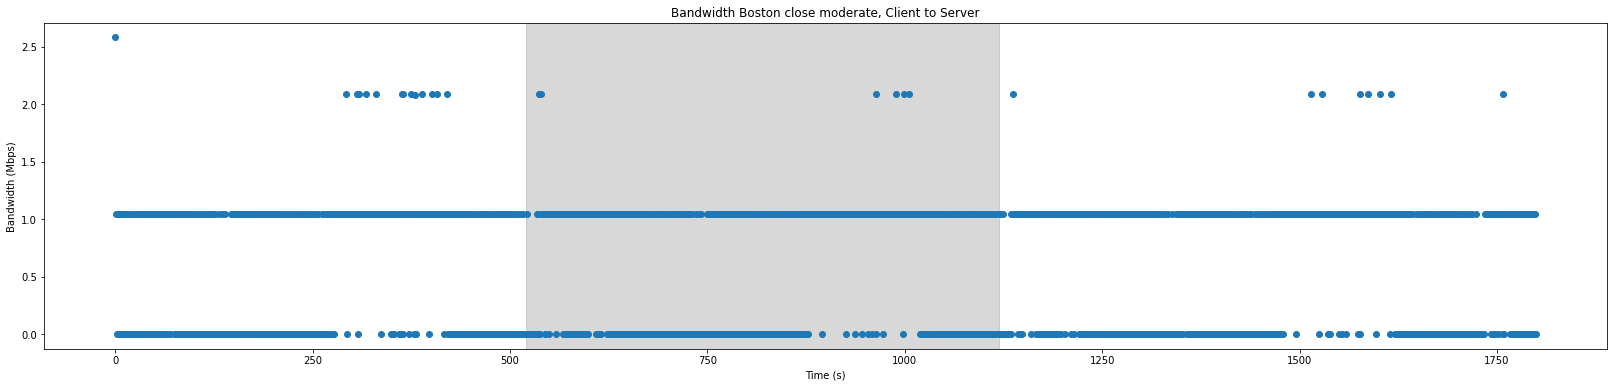

In [136]:
plot_iperf_time_series(iperf_1033_cs, title='Bandwidth Boston close moderate, Client to Server')

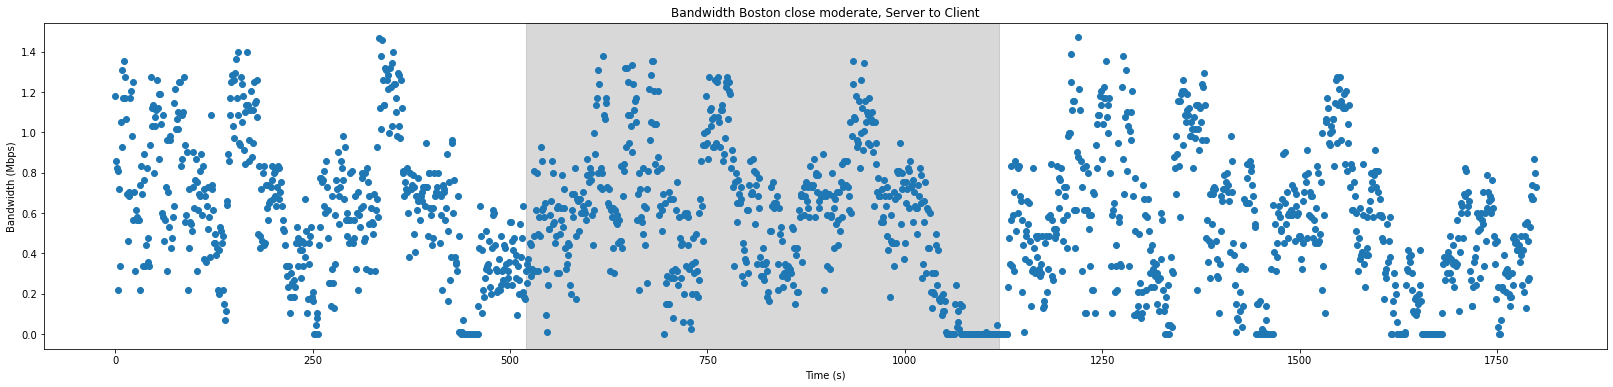

In [137]:
plot_iperf_time_series(iperf_1033_sc, title='Bandwidth Boston close moderate, Server to Client')

### Are there dropouts in bandwidth in Boston Close Static

In [138]:
iperf_1031_cs = ca.parse_iperf(get_net_path('benchmark_net_836352367_1031_iperf/iperf_client_to_server.json'))
iperf_1031_sc = ca.parse_iperf(get_net_path('benchmark_net_836352367_1031_iperf/iperf_server_to_client.json'))

In [139]:
iperf_1031_cs = cnv_Mbps(iperf_1031_cs)
iperf_1031_sc = cnv_Mbps(iperf_1031_sc)

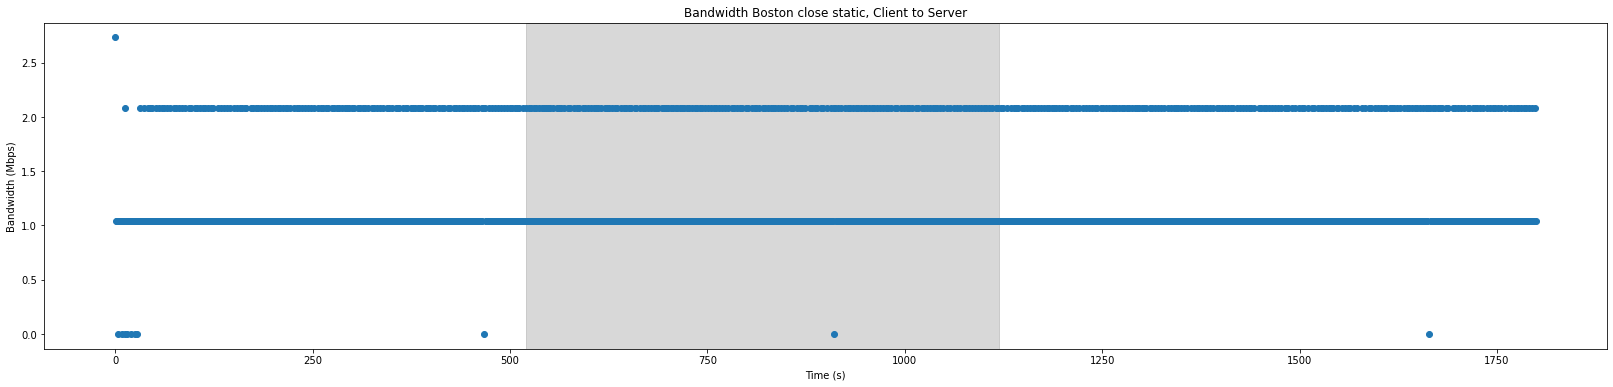

In [140]:
plot_iperf_time_series(iperf_1031_cs, title='Bandwidth Boston close static, Client to Server')

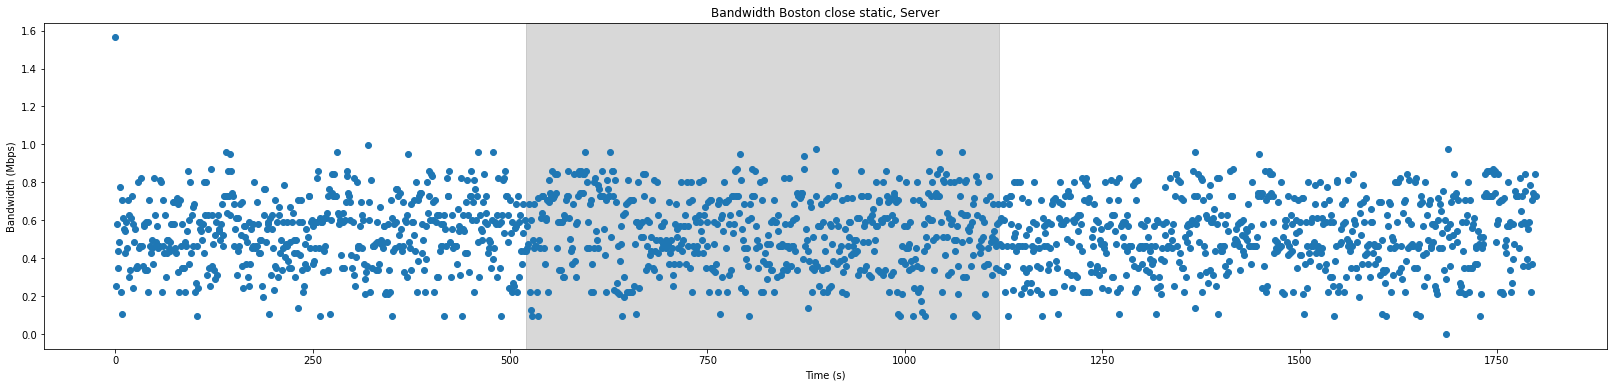

In [141]:
plot_iperf_time_series(iperf_1031_sc, title='Bandwidth Boston close static, Server')

Plots for the mailing list

In [142]:
# get only chunk that represents one scenario duration
b_1033_sc = iperf_1033_sc[520:1120]['Mbps']
b_1033_cs = iperf_1033_cs[520:1120]['Mbps']
b_1031_sc = iperf_1031_sc[520:1120]['Mbps']
b_1031_cs = iperf_1031_cs[520:1120]['Mbps']

In [143]:
def plot_bdw_mailinglist(data_sc: pd.DataFrame, data_cs: pd.DataFrame, scenario_title: str) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    ax[0].plot(data_sc, marker='o', linestyle='')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Bandwidth (Mbps)')
    ax[0].set_title(f"{scenario_title} Server->Client")

    ax[1].plot(data_cs, marker='o', linestyle='')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Bandwidth (Mbps)')
    ax[1].set_title(f"{scenario_title} Client->Server")

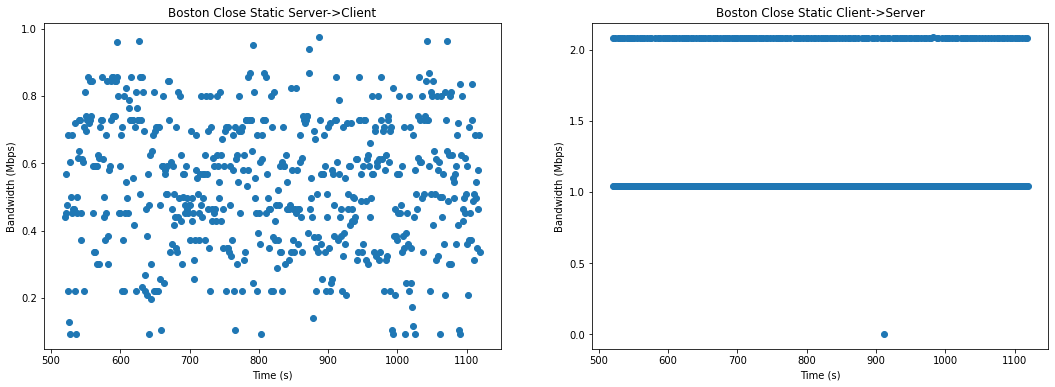

In [144]:
plot_bdw_mailinglist(b_1031_sc, b_1031_cs, "Boston Close Static")

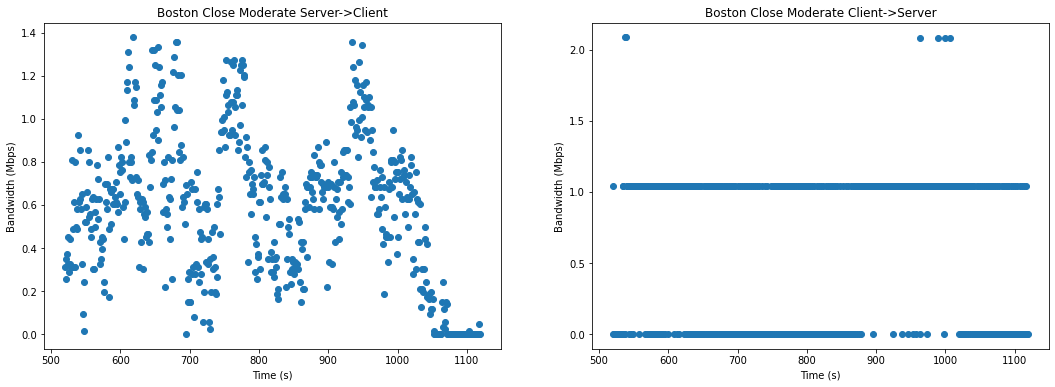

In [145]:
plot_bdw_mailinglist(b_1033_sc, b_1033_cs, "Boston Close Moderate")

# Iperf Debugging

In [146]:
iperf_1026_dbg = ca.parse(get_net_path('debug/gensync_026003316_1026.csv'), summarize=True)
iperf_1026_dbg

,algorithm,diffs,cardinality,success,bytes exchanged,ttr
0,CPI,90,10000,True,1511.0,1.245001
1,CPI,90,10000,True,1511.0,0.697011
2,CPI,90,10000,True,1511.0,1.025166
3,CPI,90,10000,True,1511.0,0.738024
4,CPI,90,10000,True,1511.0,0.737071
...,...,...,...,...,...,...
215,CPI,0,10000,True,75.0,1.760494
216,CPI,0,10000,True,75.0,0.664601
217,CPI,0,10000,True,75.0,0.639550
218,CPI,0,10000,True,75.0,0.648451


**TODO**: make sure that these `uBandwidth` and `dBandwidth` correlate to what is measured by iperf and ping separately.

With `timeout 2 iperf3 ... -R`:

In [147]:
d_1026_2s = ca.parse('plain_data/gensync_023015281_1026.csv', summarize=True)

In [148]:
incomplete = d_1026_2s[(d_1026_2s['dBandwidth'] < 0) | (d_1026_2s['uBandwidth'] < 0) | (d_1026_2s['latency'] < 0)]
incomplete.shape[0] / d_1026_2s.shape[0]

0.19090909090909092

That was overall amount of incomplete measurements.

In [149]:
incomplete.groupby('algorithm').count()['diffs'] / d_1026_2s.groupby('algorithm').count()['diffs']

algorithm
CPI       0.072727
Cuckoo    0.068182
IBLT      0.431818
Name: diffs, dtype: float64

The incomplete measurements are not uniformly distributed over all algorithms. 

The solution idea is to pick `.cpisync` server files from the data directory at random. This is in the later chapters.

In [150]:
incomplete[(incomplete['algorithm'] == 'CPI') & (incomplete['diffs'] == 50)]

,algorithm,diffs,cardinality,success,bytes exchanged,ttr,latency,uBandwidth,dBandwidth,measuremntsDuration,MasurementsStartedAt
481,CPI,50,10000,True,871.0,129.855268,-5.0,-4.0,-4.0,20504.0,2022-06-02 02:31:53
482,CPI,50,10000,True,870.0,0.674776,108.0,1384120.0,-2.0,3520.0,2022-06-02 02:35:24


In [151]:
d_1026_2s[(d_1026_2s['algorithm'] == 'CPI') & (d_1026_2s['diffs'] == 50)]['ttr'].describe()

count     10.000000
mean      13.915049
std       40.739738
min        0.655082
25%        0.672455
50%        0.894254
75%        1.622429
max      129.855268
Name: ttr, dtype: float64

Plot `uBandwidth` and `dBandwidth`as observed before each measurement.

In [152]:
d_1026_2s = d_1026_2s.sort_values('MasurementsStartedAt').reset_index(drop=True)

In [153]:
d_1026_2s

,algorithm,diffs,cardinality,success,bytes exchanged,ttr,latency,uBandwidth,dBandwidth,measuremntsDuration,MasurementsStartedAt
0,CPI,0,10000,True,75.0,0.640590,97.4,2160070.0,1101000.0,8072.0,2022-06-02 01:00:10
1,CPI,0,10000,True,75.0,0.623634,82.3,1751120.0,949248.0,4683.0,2022-06-02 01:00:21
2,CPI,0,10000,True,75.0,0.637803,57.6,1772090.0,1447030.0,4282.0,2022-06-02 01:00:51
3,CPI,0,10000,True,75.0,0.968919,81.0,960512.0,1478490.0,4137.0,2022-06-02 01:00:58
4,CPI,0,10000,True,75.0,0.886528,96.7,1751120.0,1121980.0,5053.0,2022-06-02 01:01:28
...,...,...,...,...,...,...,...,...,...,...,...
655,IBLT,90,10000,True,8771.0,0.553626,95.9,-4.0,-4.0,20504.0,2022-06-02 07:00:09
656,IBLT,90,10000,True,8771.0,0.413899,75.5,-4.0,-4.0,20504.0,2022-06-02 07:00:32
657,IBLT,90,10000,True,8771.0,3.699589,74.3,-4.0,-4.0,20504.0,2022-06-02 07:01:02
658,IBLT,90,10000,True,8771.0,66.247737,108.0,-4.0,-4.0,20504.0,2022-06-02 07:01:32


In [154]:
list(range(0, 700, 100)) + [660]

[0, 100, 200, 300, 400, 500, 600, 660]

In [155]:
def plot_bandwidth(df: pd.DataFrame, title='uBandwidth') -> None:
    fig, ax = plt.subplots(figsize=(28, 6))
    data = df['uBandwidth'] if title.startswith('uB') else df['dBandwidth']
    ax.plot(data, marker='o', linestyle='')
    ax.set_xticks(list(range(0, 700, 100)) + [660])
    ax.set_xticklabels(['June 2nd, 1:00:10 AM', *['']*6, 'June 2nd, 7:03:59 AM'])
    ax.set_xlabel('Experiment Duration')
    ax.set_ylabel('Bandwidth (Mbps)')
    plt.title(title)

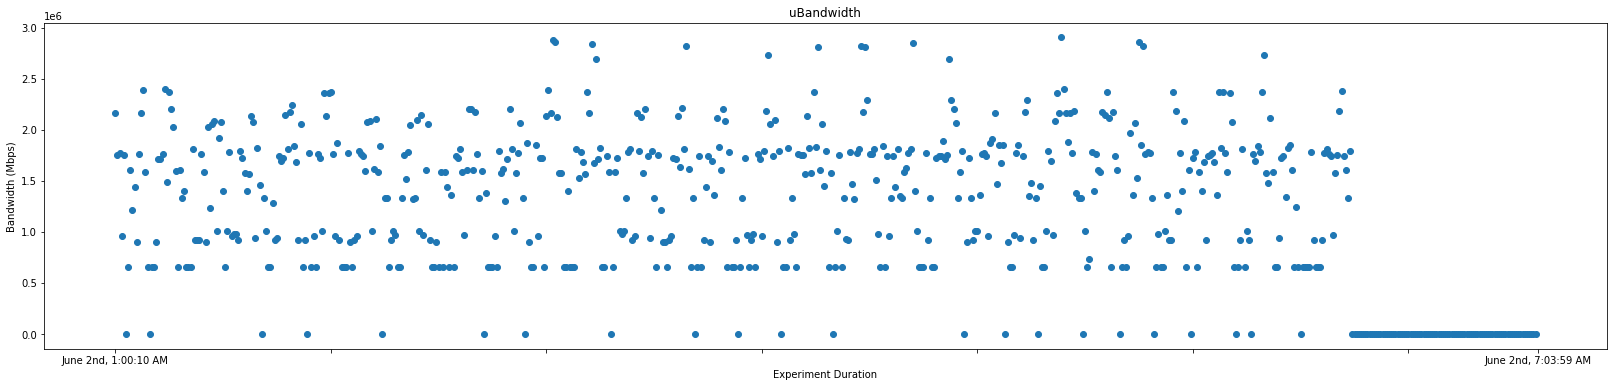

In [156]:
plot_bandwidth(d_1026_2s, title='uBandwidth')

In [157]:
d_1026_2s[550:600]

,algorithm,diffs,cardinality,success,bytes exchanged,ttr,latency,uBandwidth,dBandwidth,measuremntsDuration,MasurementsStartedAt
550,IBLT,0,10000,True,249.0,65.163151,-5.0,-4.0,-4.0,20504.0,2022-06-02 05:51:49
551,IBLT,0,10000,True,249.0,0.501655,82.0,651264.0,427008.0,8246.0,2022-06-02 05:53:44
552,IBLT,0,10000,True,249.0,0.756634,106.0,651264.0,557056.0,9998.0,2022-06-02 05:53:55
553,IBLT,0,10000,True,249.0,0.446577,99.7,651264.0,509952.0,7665.0,2022-06-02 05:54:25
554,IBLT,0,10000,True,249.0,1.842343,134.0,651264.0,616448.0,6806.0,2022-06-02 05:54:36
555,IBLT,0,10000,True,249.0,0.433685,62.4,1782580.0,616448.0,5605.0,2022-06-02 05:55:06
556,IBLT,0,10000,True,249.0,0.449450,95.7,924672.0,664576.0,6800.0,2022-06-02 05:55:14
557,IBLT,0,10000,True,249.0,1.159480,134.0,651264.0,901120.0,6766.0,2022-06-02 05:55:44
558,IBLT,0,10000,True,249.0,1.456439,95.6,651264.0,533504.0,5506.0,2022-06-02 05:55:54
559,IBLT,0,10000,True,249.0,1.741507,66.0,652288.0,924672.0,8366.0,2022-06-02 05:56:24


In [158]:
d_1026_2s[(d_1026_2s['diffs'] == 100) & (d_1026_2s['cardinality'] == 10000)]

,algorithm,diffs,cardinality,success,bytes exchanged,ttr,latency,uBandwidth,dBandwidth,measuremntsDuration,MasurementsStartedAt
20,CPI,100,10000,True,1671.0,0.700866,109.0,1709180.0,391168.0,4021.0,2022-06-02 01:17:44
21,CPI,100,10000,True,1671.0,1.189704,79.1,1709180.0,522240.0,4829.0,2022-06-02 01:17:51
22,CPI,100,10000,True,1671.0,2.751560,-5.0,1761610.0,-4.0,12197.0,2022-06-02 01:18:00
23,CPI,100,10000,True,1671.0,0.735320,80.7,2401240.0,1583350.0,4317.0,2022-06-02 01:18:30
24,CPI,100,10000,True,1671.0,0.737258,94.8,1488980.0,1457520.0,4031.0,2022-06-02 01:19:00
25,CPI,100,10000,True,1670.0,0.714234,76.8,2369780.0,1478490.0,4353.0,2022-06-02 01:19:30
26,CPI,100,10000,True,1671.0,0.698806,57.1,2202010.0,1488980.0,4168.0,2022-06-02 01:19:39
27,CPI,100,10000,True,1671.0,0.737064,59.7,2023750.0,1019900.0,4549.0,2022-06-02 01:20:09
28,CPI,100,10000,True,1671.0,0.777431,129.0,1593840.0,1509950.0,4234.0,2022-06-02 01:20:39
29,CPI,100,10000,True,1671.0,0.735323,94.1,651264.0,1405090.0,4406.0,2022-06-02 01:21:09


## Experiments with randomized experiment execution order

# Scenario 1009 - Sanity Check

Scenario 1009 is a Colosseum debug scenario. There is no path loss or any other factors that should affect the TCP performance over the duration of the scenario.

In [159]:
d_1009_ping = ca.parse_ping(get_net_path('1009/ping.txt'))

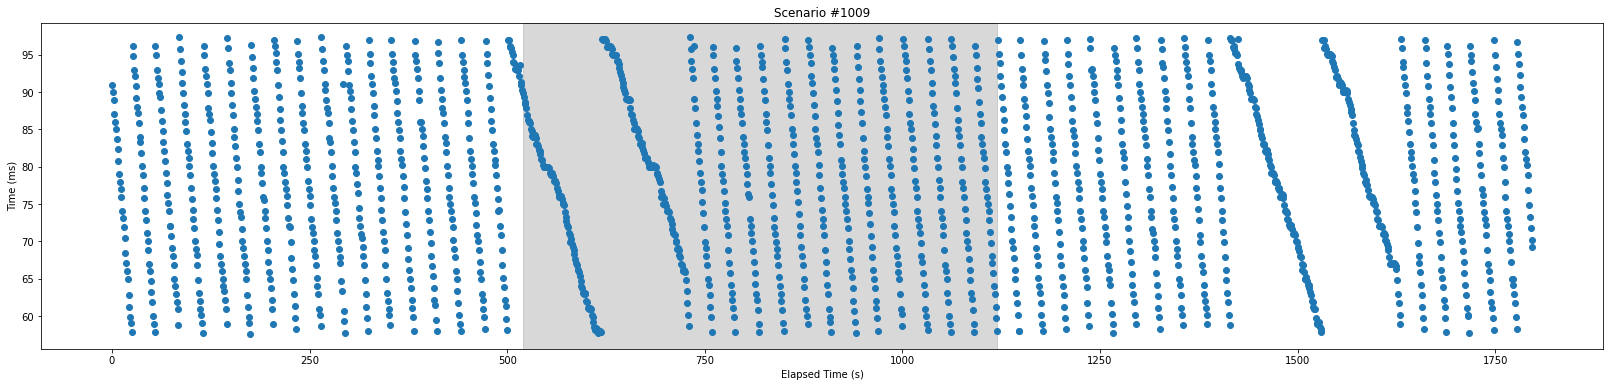

In [160]:
plot_rtt_time_series(d_1009_ping, title='Scenario #1009')

Ping measurements still exhibit the same pattern.

In [161]:
d_1009_cts = ca.parse_iperf(get_net_path('1009/iperf_client_to_server.json'))
d_1009_stc = ca.parse_iperf(get_net_path('1009/iperf_server_to_client.json'))

In [162]:
d_1009_cts = cnv_Mbps(d_1009_cts)
d_1009_stc = cnv_Mbps(d_1009_stc)

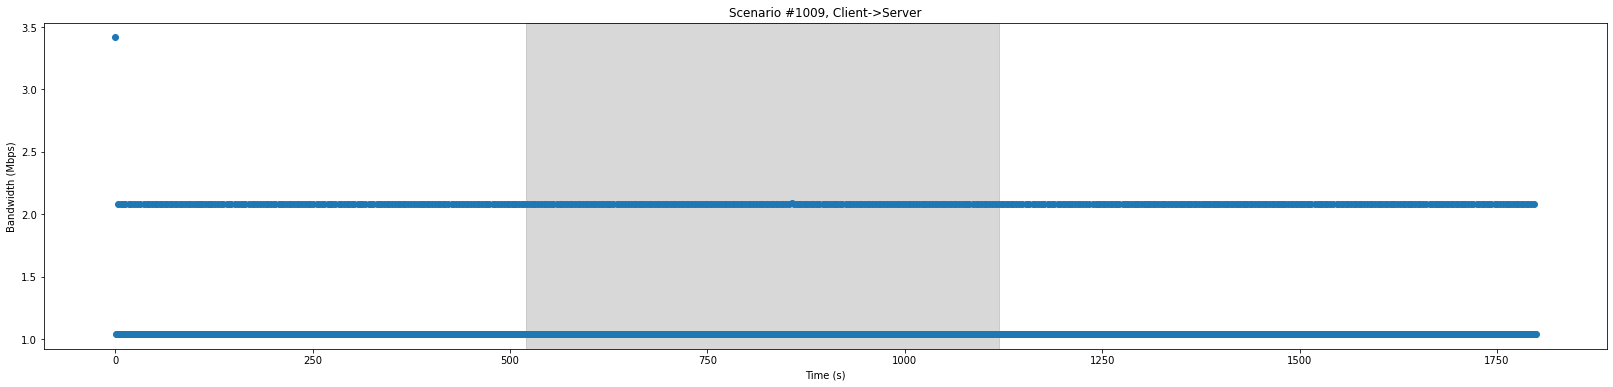

In [163]:
plot_iperf_time_series(d_1009_cts, title='Scenario #1009, Client->Server')

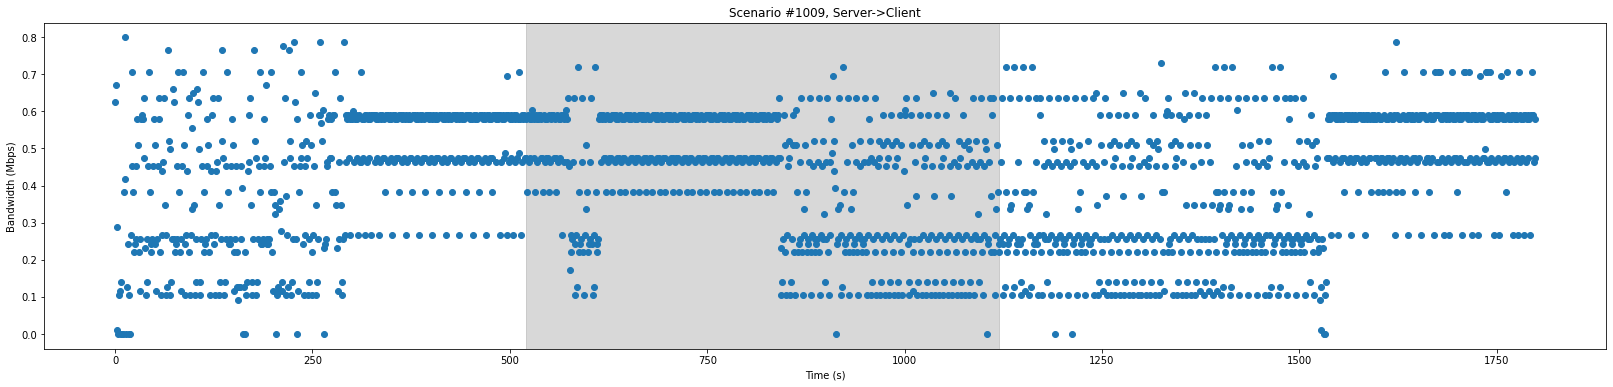

In [164]:
plot_iperf_time_series(d_1009_stc, title='Scenario #1009, Server->Client')

And there are also some bandwidth variations.

## UDP measurements

UDP's counterpart of TCP throughput is UDP-goodput. Goodput is the amount of UDP packets received per second. Sender may send more packets than the receiver receives. The difference is typically registered as packet loss.

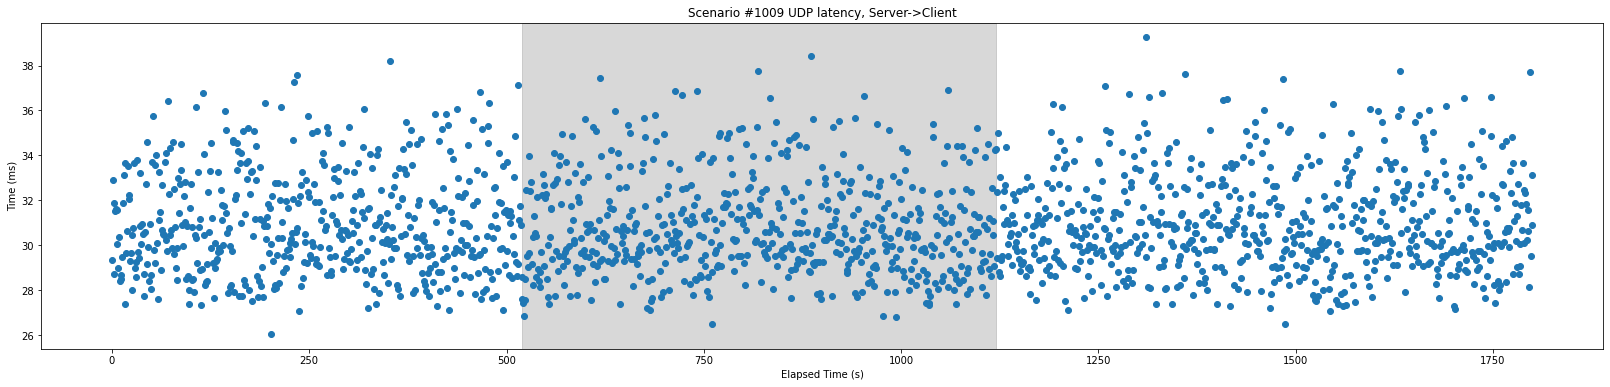

In [165]:
data = ca.parse_iperf_v2('plain_data/network/udp/benchmark_net_020511352_1009/iperf2_client.txt')
plot_rtt_time_series(data, 'Scenario #1009 UDP latency, Server->Client')

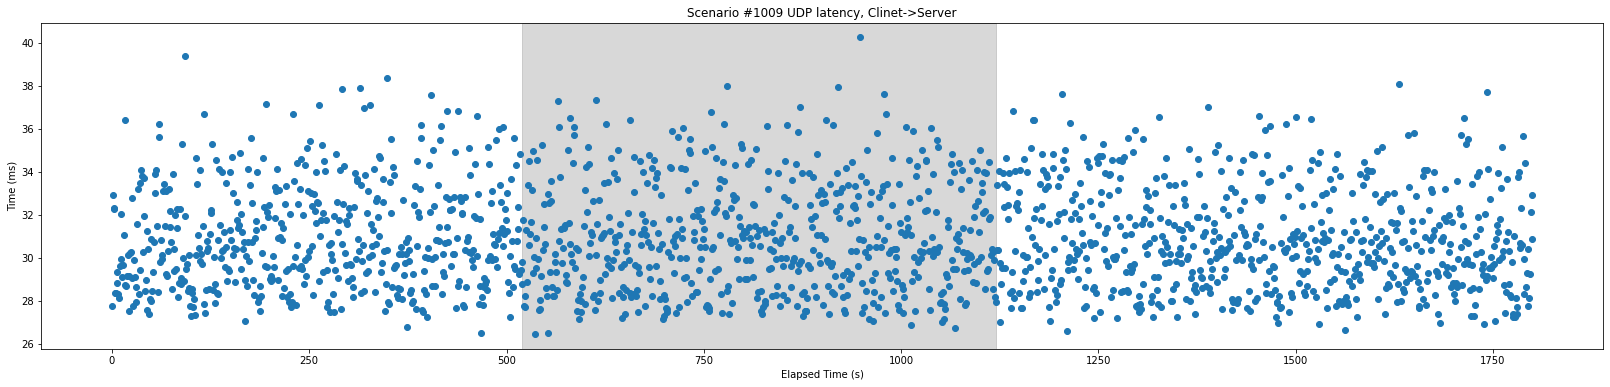

In [166]:
data = ca.parse_iperf_v2('plain_data/network/udp/benchmark_net_020511352_1009/iperf2_server.txt')
plot_rtt_time_series(data, 'Scenario #1009 UDP latency, Clinet->Server')

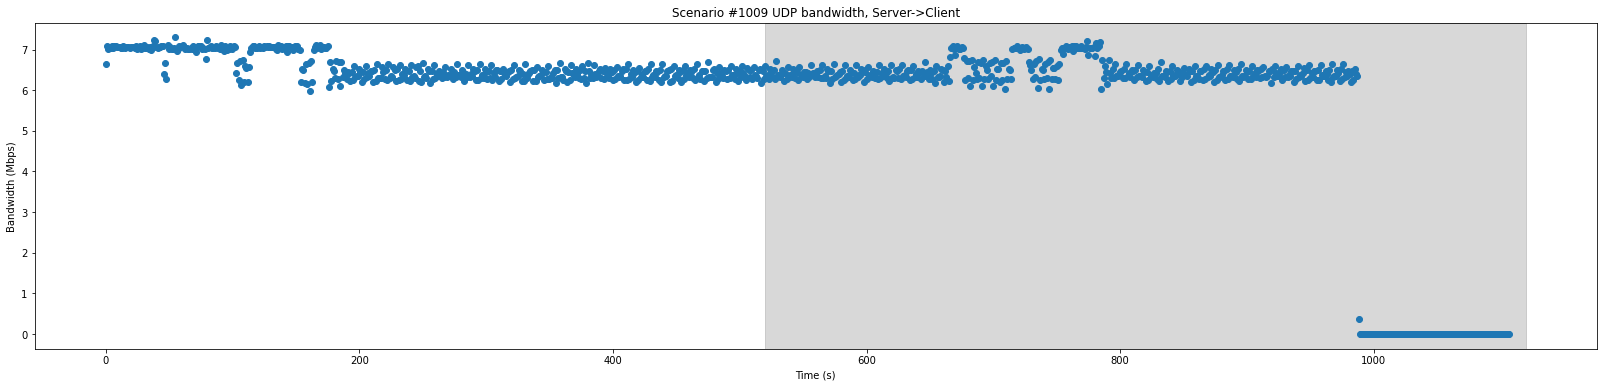

In [168]:
data = ca.parse_iperf('plain_data/network/udp/benchmark_net_020550482_1009/iperf3_server_to_client.json')
plot_iperf_time_series(cnv_Mbps(data), 'Scenario #1009 UDP bandwidth, Server->Client')

plain_data/network/udp/benchmark_net_020550482_1009/iperf3_server_logs.json seems to have more than one JSON object. Second object starts after position 1258392.


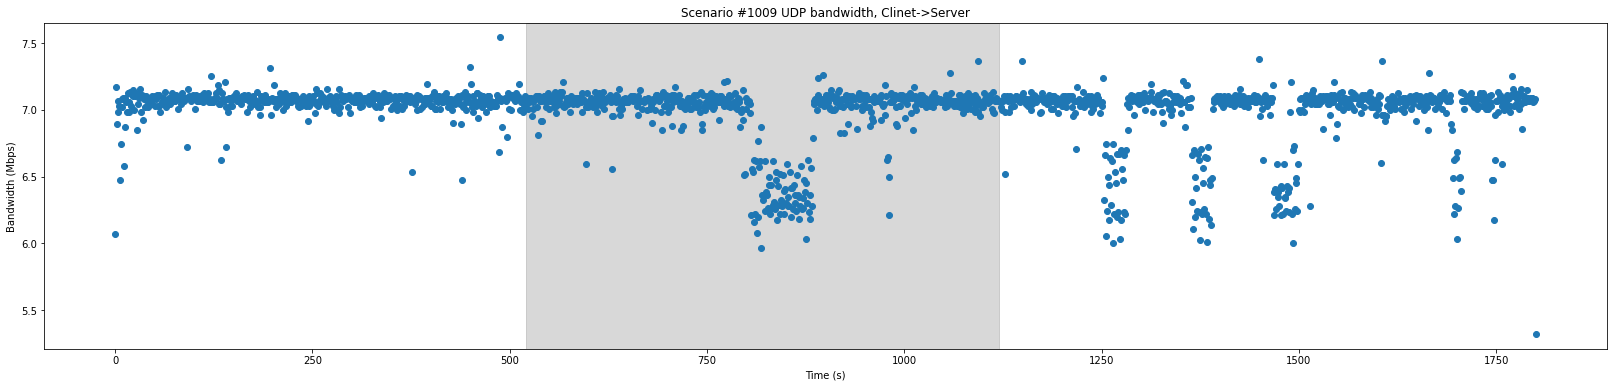

In [170]:
data = ca.parse_iperf('plain_data/network/udp/benchmark_net_020550482_1009/iperf3_server_logs.json')
plot_iperf_time_series(cnv_Mbps(data), 'Scenario #1009 UDP bandwidth, Clinet->Server')

**TODO**: How does latency behaves with different target throughputs?